In [1]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

In [2]:
HARTREE_TO_EV = 27.211386245988
train_subset = "0:1500"  #input for ase.io.read command
test_subset = "1500:2000"  #input to ase.io.read command
environments_for_fitting = 100  #number of environments to fit nice transfomers
GRID = [150, 200, 350, 500, 750, 1000, 1500, 2000, 2500]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
MAGIC_NUMBER = 10000

train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean
print(np.min(train_energies), np.max(train_energies))

-7.519471700884196 26.095904038212893


# NICE cython

In [3]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
       
    ],
                           )

In [4]:
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER



100%|██████████| 2/2 [00:00<00:00, 891.08it/s]


In [5]:
nice = get_nice()
np.random.seed(0)
nice.fit(train_coefficients[6][:environments_for_fitting])

/home/sergey/.local/lib/python3.8/site-packages/nice/blocks/compressors.py:94: RuntimeWarning: given data is less than desired number of points to fit pca. Desired number of points to fit pca is 200, while number of vectors is 100, dimensionality of single vector (lambd + 1) is 1, i. e. total number of points is 100. Number of pca components is 20.
  warnings.warn(
/home/sergey/.local/lib/python3.8/site-packages/nice/blocks/purifiers.py:144: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 30, desired number of data points is 300, actual number of data points (n_env * (l + 1)) is 100, since number of environments is 100, and l is 0.
  warnings.warn(
/home/sergey/.local/lib/python3.8/site-packages/nice/blocks/purifiers.py:144: UserWarning: Amount of provided data is less than the desired one to fit InvariantsPurifer. Number of old features is 30, desired number of data points is 300, actual number of data points (n_env

In [6]:
train_features = nice.transform(train_coefficients[6], return_only_invariants = True)
test_features = nice.transform(test_coefficients[6], return_only_invariants = True)

In [7]:
for key in train_features.keys():
    print(key, train_features[key].shape)
#print(train_features[1][0:10])
#print(train_features[2][0:10])

1 (1500, 10)
2 (1500, 20)
3 (1500, 20)
4 (1500, 20)


In [8]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lr(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

(1500, 10)
(1500, 30)
(1500, 50)
(1500, 70)


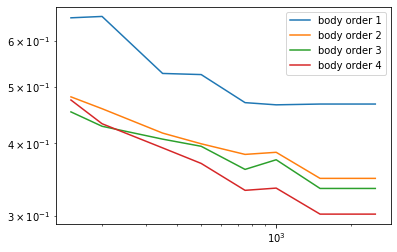

In [9]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# NICE pytorch

In [10]:
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *

In [11]:
def split(coefficients):
    lambd_max = max(coefficients.keys())
    even, odd = {}, {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[lambd]
        else:
            odd[str(lambd)] = coefficients[lambd]
    return even, odd


train_coefficients = get_coefs(train_structures, HYPERS, all_species)
central = get_central_species(train_structures)
mask = central == 6
for key in train_coefficients.keys():
    train_coefficients[key] = train_coefficients[key][mask]
    
test_coefficients = get_coefs(test_structures, HYPERS, all_species)
central = get_central_species(test_structures)
mask = central == 6
for key in test_coefficients.keys():
    test_coefficients[key] = test_coefficients[key][mask]
                                                   
for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER
    
train_even, train_odd = split(train_coefficients)
test_even, test_odd = split(test_coefficients)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

0 torch.Size([1500, 10, 1])
2 torch.Size([1500, 10, 5])
4 torch.Size([1500, 10, 9])
0 torch.Size([500, 10, 1])
2 torch.Size([500, 10, 5])
4 torch.Size([500, 10, 9])


In [12]:
blocks = [BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20))]
nice = NICE(blocks)
for_fit_even, for_fit_odd = {}, {}
for key in train_even.keys():
    for_fit_even[key] = train_even[key][:environments_for_fitting]
    print(for_fit_even[key].shape)
for key in test_odd.keys():
    for_fit_odd[key] = train_odd[key][:environments_for_fitting]
    print(for_fit_odd[key].shape)
np.random.seed(0)   
nice.fit(for_fit_even, for_fit_odd)

torch.Size([100, 10, 1])
torch.Size([100, 10, 5])
torch.Size([100, 10, 9])
torch.Size([100, 10, 3])
torch.Size([100, 10, 7])
torch.Size([100, 10, 11])


In [13]:
def convert(features):
    result = {}
    for i in range(len(features)):
        #print(features[i].keys())
        result[i + 1] = features[i]['0'].squeeze().data.cpu().numpy()
    return result

In [14]:
train_features, _ = nice(train_even, train_odd)
train_features = convert(train_features)

test_features, _ = nice(test_even, test_odd)
test_features = convert(test_features)

In [15]:
for key in train_features.keys():
    print(key, train_features[key].shape)

1 (1500, 10)
2 (1500, 20)
3 (1500, 20)
4 (1500, 20)


In [16]:
'''print(train_features[1][0:10])
print(train_features[2][0:10])'''

'print(train_features[1][0:10])\nprint(train_features[2][0:10])'

(1500, 10)
(1500, 30)
(1500, 50)
(1500, 70)


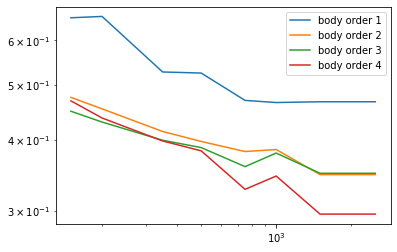

In [17]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()